**No history**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
from sklearn.neighbors import BallTree
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import math
import warnings
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def apply_price_transformation(train_data, inverse=False):
    """
    Apply log transformation to price data or inverse the transformation
   
    Parameters:
    -----------
    train_data : DataFrame
        The dataframe containing price data
    inverse : bool
        If True, apply inverse transformation; otherwise apply log transformation
       
    Returns:
    --------
    DataFrame
        Modified dataframe with transformed prices
    """
    df = train_data.copy()
   
    if not inverse:
        # Apply log transformation
        print("Applying log transformation to price data")
        df['original_price'] = df['price']  # Store original price
        df['price'] = np.log1p(df['price'])  # log1p to handle zero values
    else:
        # Inverse transform
        print("Inverting log transformation for predictions")
        df['price'] = np.expm1(df['price'])  # expm1 is the inverse of log1p
   
    return df


def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1, train_data_only=None):
    """Enhanced spatial features while maintaining existing structure
    
    Parameters:
    -----------
    df : DataFrame
        The data to create features for
    k_neighbors : int
        Number of neighbors to use for KNN features
    chunk_size : int
        Size of chunks for parallel processing
    n_jobs : int
        Number of parallel jobs
    train_data_only : DataFrame, optional
        If provided, use only this data for computing the KNN features
        This prevents data leakage by ensuring test listings don't influence each other
    """
    # Adjust k_neighbors if the dataset is small
    reference_data = train_data_only if train_data_only is not None else df
    actual_k = min(k_neighbors, len(reference_data) - 1)  # Make sure k is at most n-1
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': []
        # ,'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    # Use only training data for the reference tree to prevent data leakage
    all_coords = np.radians(reference_data[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = reference_data['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, we need special handling
        if k_query == 1:
            # Just return zeros or appropriate values for a single point
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                # 'price_diff_from_neighbors': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data if we have multiple points
        # Handle the case where k_query is 2 (self + 1 neighbor)
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))  # Only one neighbor, so weight is 1
        else:
            # Convert distances to weights (inverse distance weighting)
            weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore NaN warnings
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            # Handle single-neighbor case for median and range
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            # Weighted prices
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            # 'price_diff_from_neighbors': chunk_data['price'].values - mean_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,  # Use adjusted k value
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0  # Set to zero if std is zero
    
    return spatial_features

def run_rolling_window_xgboost(train_path, train_ids_path, test_ids_path, output_dir=None, window_size=35, n_splits=5, sample_size=None):
    """
    Run XGBoost with rolling window cross-validation for predicting prices without price history.
    Uses separate listing IDs for training and testing to prevent data leakage.
    
    Parameters:
    -----------
    train_path : str
        Path to the Topic2_Train.csv file
    train_ids_path : str
        Path to text file with training listing IDs
    test_ids_path : str
        Path to text file with test listing IDs
    output_dir : str, optional
        Directory to save results
    window_size : int, optional
        Size of the rolling window in days
    n_splits : int, optional
        Number of splits for time series cross-validation
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Load listing IDs for train/test split
    print("Loading train/test listing IDs...")
    with open(train_ids_path, 'r') as f:
        train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
    with open(test_ids_path, 'r') as f:
        test_listing_ids = [int(line.strip()) for line in f.readlines()]
    
    print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")

    # Drop the price_lag_1d column if it exists
    if 'price_lag_1d' in train_data.columns:
        print("Dropping price_lag_1d column from the dataset")
        train_data = train_data.drop('price_lag_1d', axis=1)
    

    if 'simulated_price' in train_data.columns:
        print("Dropping simulated_price column from the dataset")
        train_data = train_data.drop('simulated_price', axis=1)
    # For testing - take only a small sample of listings if specified
    if sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.7), replace=False)
        selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.3), replace=False)
        train_listing_ids = selected_train.tolist()
        test_listing_ids = selected_test.tolist()
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 2/8/24 (as specified)
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Check if we have data for the entire expected range
    print(f"Date range in filtered data: {train_data['date'].min()} to {train_data['date'].max()}")
    print(f"Number of days with data: {len(train_data['date'].dt.date.unique())}")

    # Get unique dates and ensure they are properly sorted
    unique_dates = sorted(train_data['date'].dt.date.unique())
    first_date = unique_dates[0]
    last_date = unique_dates[-1]

    # Check if there's a gap between the expected start date and actual first date
    if first_date > start_date.date():
        print(f"Warning: No data found between {start_date.date()} and {first_date}")
        print(f"Using available data starting from {first_date}")
    
    # Sort by date
    train_data = train_data.sort_values('date')
    
    # Create explicit test periods - last 5 weeks (35 days) split into 5 equal parts (7 days each)
    last_35_days = unique_dates[-35:]
    
    # Define explicit test periods - each 7 days
    test_periods = []
    for i in range(n_splits):
        start_idx = i * 7
        end_idx = start_idx + 7
        # Make sure we don't go beyond the available data
        if end_idx <= len(last_35_days):
            test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
    
    # Adjust n_splits if we couldn't create enough test periods
    n_splits = len(test_periods)
    
    print(f"Created {n_splits} test periods:")
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"  Period {i+1}: {test_start} to {test_end}")
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Storage for results
    cv_results = []
    feature_importance_over_time = []
    
    # Run time series cross-validation using our explicit test periods
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"\nSplit {i+1}/{n_splits}")
        
        # Define training period: everything before test_start
        train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
        train_end_date = train_end.date()
        
        print(f"Training period: {unique_dates[0]} to {train_end_date}")
        print(f"Testing period: {test_start} to {test_end}")
        
        # Split by date first
        train_date_mask = train_data['date'].dt.date <= train_end_date
        test_date_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
        
        date_filtered_train = train_data[train_date_mask]
        date_filtered_test = train_data[test_date_mask]
        
        # Now further split by listing IDs
        train_id_mask = date_filtered_train['listing_id'].isin(train_listing_ids)
        test_id_mask = date_filtered_test['listing_id'].isin(test_listing_ids)
        
        split_train_data = date_filtered_train[train_id_mask]
        split_test_data = date_filtered_test[test_id_mask]
        
        print(f"Train data: {len(split_train_data)} rows, {len(split_train_data['listing_id'].unique())} unique listings")
        print(f"Test data: {len(split_test_data)} rows, {len(split_test_data['listing_id'].unique())} unique listings")
        
        # Create spatial features using only training data as reference
        # Pass training data to prevent leakage
        full_train_data = train_data[train_data['listing_id'].isin(train_listing_ids)]
        train_spatial = create_spatial_features(split_train_data, train_data_only=full_train_data)
        test_spatial = create_spatial_features(split_test_data, train_data_only=full_train_data)
        
        # Prepare feature matrices
        X_train = pd.concat([
            split_train_data.drop(['listing_id', 'date', 'price'], axis=1), 
            train_spatial
        ], axis=1)
        
        X_test = pd.concat([
            split_test_data.drop(['listing_id', 'date', 'price'], axis=1), 
            test_spatial
        ], axis=1)
        
        y_train = split_train_data['price']
        y_test = split_test_data['price']
        
        # Ensure X_train and X_test have the same columns
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
            
        # Ensure the columns are in the same order
        X_test = X_test[X_train.columns]
        
        # Train the model
        print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        # Make predictions
        y_pred = xgb_model.predict(X_test)
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'split': i
        })
        feature_importance_over_time.append(feature_importance)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred) if len(set(y_test)) > 1 else np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        print(f"Split {i+1} Results - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
        
        # Store results for this split
        split_results = pd.DataFrame({
            'split': i,
            'date': split_test_data['date'],
            'listing_id': split_test_data['listing_id'],
            'price': y_test,
            'predicted': y_pred,
            'error': y_test - y_pred,
            'abs_error': np.abs(y_test - y_pred),
            'pct_error': np.abs((y_test - y_pred) / (y_test + 1e-8)) * 100
        })
        
        cv_results.append(split_results)
    
    # Combine all results
    all_results = pd.concat(cv_results, ignore_index=True)
    all_feature_importance = pd.concat(feature_importance_over_time, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price']
    y_pred = all_results['predicted']
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate split-level metrics
    split_metrics = []
    for split in range(n_splits):
        split_data = all_results[all_results['split'] == split]
        if not split_data.empty:
            y_true_split = split_data['price']
            y_pred_split = split_data['predicted']
            
            split_metrics.append({
                'split': split,
                'rmse': np.sqrt(mean_squared_error(y_true_split, y_pred_split)),
                'mae': mean_absolute_error(y_true_split, y_pred_split),
                'r2': r2_score(y_true_split, y_pred_split) if len(set(y_true_split)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_split - y_pred_split) / (y_true_split + 1e-8))) * 100,
                'n_samples': len(y_true_split)
            })
    
    split_metrics_df = pd.DataFrame(split_metrics)
    
    # Calculate daily metrics
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    daily_metrics = []
    for day, group in all_results.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    # Error analysis
    errors = all_results['error'].values
    error_autocorr = acf(errors, nlags=7)[1:]  # Exclude lag 0
    
    # Create a results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'split_metrics': split_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'feature_importance': all_feature_importance,
        'error_autocorrelation': error_autocorr,
        'train_listings': len(train_listing_ids),
        'test_listings': len(test_listing_ids)
    }
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save all results
        results_file = os.path.join(output_dir, 'xgboost_listing_split_results.csv')
        all_results.to_csv(results_file, index=False)
        print(f"Results saved to {results_file}")
        
        # Save metrics
        metrics_file = os.path.join(output_dir, 'xgboost_listing_split_metrics.csv')
        daily_metrics_df.to_csv(metrics_file, index=False)
        print(f"Daily metrics saved to {metrics_file}")
        
        # Save feature importance
        importance_file = os.path.join(output_dir, 'xgboost_listing_split_feature_importance.csv')
        all_feature_importance.to_csv(importance_file, index=False)
        print(f"Feature importance saved to {importance_file}")
        
        # Save summary
        with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
            f.write(f"XGBoost Rolling Window CV Model Summary with Listing ID Split\n")
            f.write(f"==========================================================\n\n")
            f.write(f"Window size: {window_size} days\n")
            f.write(f"Number of splits: {n_splits}\n")
            f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n")
            f.write(f"Number of training listings: {len(train_listing_ids)}\n")
            f.write(f"Number of test listings: {len(test_listing_ids)}\n\n")
            f.write(f"Overall Metrics:\n")
            for k, v in overall_metrics.items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print_rolling_window_summary(evaluation_results)
    
    # Create plots
    plot_rolling_window_results(evaluation_results)
    
    return evaluation_results

def print_rolling_window_summary(evaluation_results):
    """Print a summary of rolling window cross-validation results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    # Print new info about listing splits if available
    train_listings = evaluation_results.get('train_listings', 'N/A')
    test_listings = evaluation_results.get('test_listings', 'N/A')
    
    print("\n===== ROLLING WINDOW XGBOOST MODEL WITH LISTING ID SPLIT =====")
    if train_listings != 'N/A':
        print(f"Using {train_listings} listings for training and {test_listings} listings for testing")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    # Calculate overall feature importance by averaging across splits
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features (No Price History) ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_rolling_window_results(evaluation_results):
    """Plot the results from rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Add title showing we're using listing ID split
    fig.suptitle('XGBoost Model Evaluation with Listing ID Split', fontsize=16)
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Create plot for feature importance
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.groupby('feature')['importance'].mean().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette='viridis'
    )
    plt.title('Top 10 Features (No Price History)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation
    error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
    lags = range(len(error_acf))
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, error_acf, alpha=0.7)
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Error Autocorrelation')
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Performance by listing ID count
    # Group by listing ID and calculate average absolute error for each listing
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    listing_errors = listing_errors.sort_values('abs_error')
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(listing_errors)), listing_errors['abs_error'], alpha=0.6)
    plt.axhline(y=listing_errors['abs_error'].mean(), color='r', linestyle='--', 
                label=f'Mean: {listing_errors["abs_error"].mean():.2f}')
    plt.title('Average Absolute Error by Listing')
    plt.xlabel('Listing Index (sorted by error)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Path to data files
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train2.csv"
    train_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt"
    test_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt"
    
    # Output directory
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_ListingSplit"
    
    # Run the model
    results = run_rolling_window_xgboost(
        train_path=train_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        output_dir=output_dir,
        window_size=35,  # 5 weeks
        n_splits=5,
        sample_size=None  # Set to a number like 1000 for testing, None to use all data
    )

Processing dataset: train2.csv
Loading data...
Loading train/test listing IDs...
Loaded 6291 train IDs and 1573 test IDs
Dropping simulated_price column from the dataset
Date range in filtered data: 2023-08-07 00:00:00 to 2024-02-08 00:00:00
Number of days with data: 186
Using available data starting from 2023-08-07
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08

Split 1/5
Training period: 2023-08-07 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11
Train data: 903142 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 903142 samples, testing on 11011 samples
Split 1 Results - RMSE: 0.8778, MAE: 0.6020, R²: 0.0647, MAPE: 203.49%

Split 2/5
Training period: 2023-08-07 to 2024-01-11
Testing period: 2024-01-12 to 2024-01-18
Train data: 947179 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 947179 samples, testing on 11011 samples
Split 2 Results - RMSE: 0.8572, MAE: 0.5893, R²: 0.0645, MAPE: 188.72%

Split 3/5
Training period: 2023-08-07 to 2024-01-18
Testing period: 2024-01-19 to 2024-01-25
Train data: 991216 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


KeyboardInterrupt: 

**With history**

Processing dataset: train_up3.csv
Loading data...
Loading train/test listing IDs...
Loaded 6291 train IDs and 1573 test IDs
Applying log transformation to price data
Date range in filtered data: 2023-08-07 00:00:00 to 2024-02-08 00:00:00
Number of days with data: 186
Using available data starting from 2023-08-07
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08

Split 1/5
Training period: 2023-08-07 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11
Train data: 903142 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 903142 samples, testing on 11011 samples
Inverting log transformation for predictions
Split 1 Results - RMSE: 62.7941, MAE: 31.1252, R²: 0.8482, MAPE: 14.59%

Split 2/5
Training period: 2023-08-07 to 2024-01-11
Testing period: 2024-01-12 to 2024-01-18
Train data: 947179 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 947179 samples, testing on 11011 samples
Inverting log transformation for predictions
Split 2 Results - RMSE: 57.7194, MAE: 25.5435, R²: 0.8655, MAPE: 10.39%

Split 3/5
Training period: 2023-08-07 to 2024-01-18
Testing period: 2024-01-19 to 2024-01-25
Train data: 991216 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 991216 samples, testing on 11011 samples
Inverting log transformation for predictions
Split 3 Results - RMSE: 53.6584, MAE: 24.1451, R²: 0.8857, MAPE: 9.54%

Split 4/5
Training period: 2023-08-07 to 2024-01-25
Testing period: 2024-01-26 to 2024-02-01
Train data: 1035253 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 1035253 samples, testing on 11011 samples
Inverting log transformation for predictions
Split 4 Results - RMSE: 53.8069, MAE: 22.9715, R²: 0.8875, MAPE: 9.18%

Split 5/5
Training period: 2023-08-07 to 2024-02-01
Testing period: 2024-02-02 to 2024-02-08
Train data: 1079290 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 1079290 samples, testing on 11011 samples
Inverting log transformation for predictions
Split 5 Results - RMSE: 51.6729, MAE: 22.5245, R²: 0.8966, MAPE: 9.03%
Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_ListingSplit\xgboost_listing_split_results.csv
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_ListingSplit\xgboost_listing_split_metrics.csv
Feature importance saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_ListingSplit\xgboost_listing_split_feature_importance.csv

===== ROLLING WINDOW XGBOOST MODEL WITH LISTING ID SPLIT =====
Using 6291 listings for training and 1573 listings for testing

=== Overall Metrics ===
RMSE: 56.0698
MAE: 25.2620
R²: 0.8767
MAPE: 10.5455%
Explained Variance: 0.8816
Median Abs Error: 8.9432

=== Split Performance ===
 split      rmse       mae      mape       r2  n_samples
     0 62.794122 31.125170 14.588025 0.848239      11011
     1 57.719443 25.

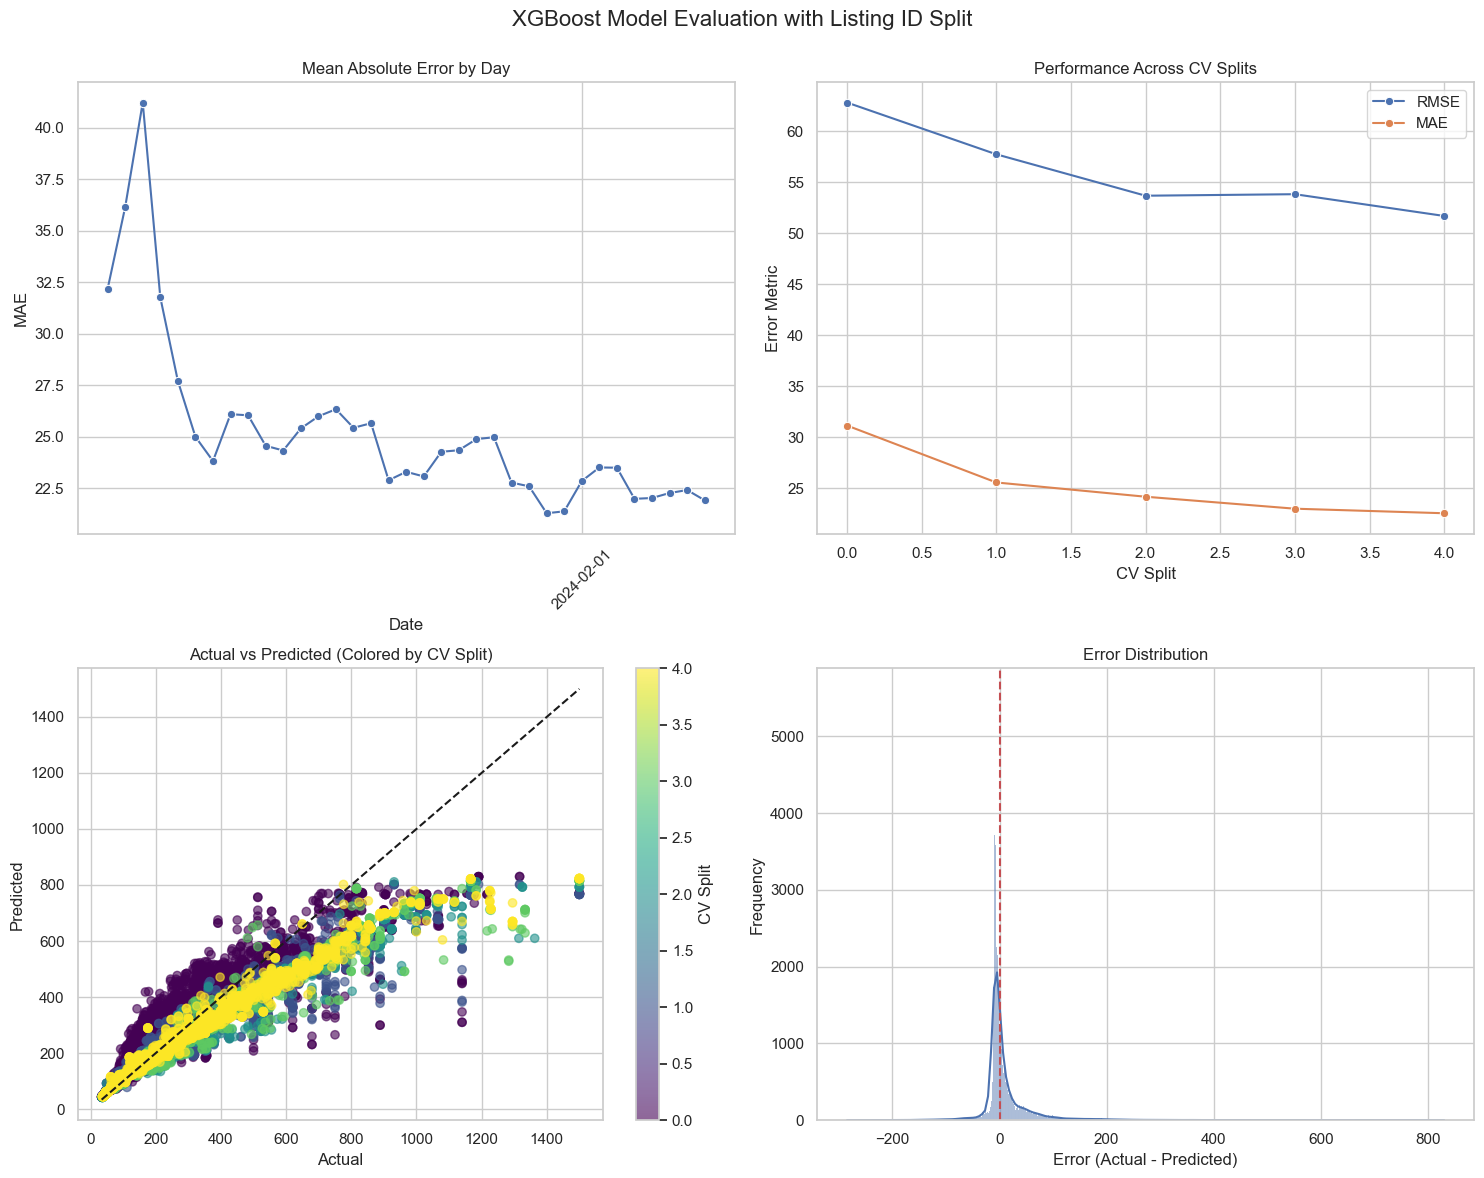

C:\Users\mvk\AppData\Local\Temp\ipykernel_32316\617104753.py:661: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


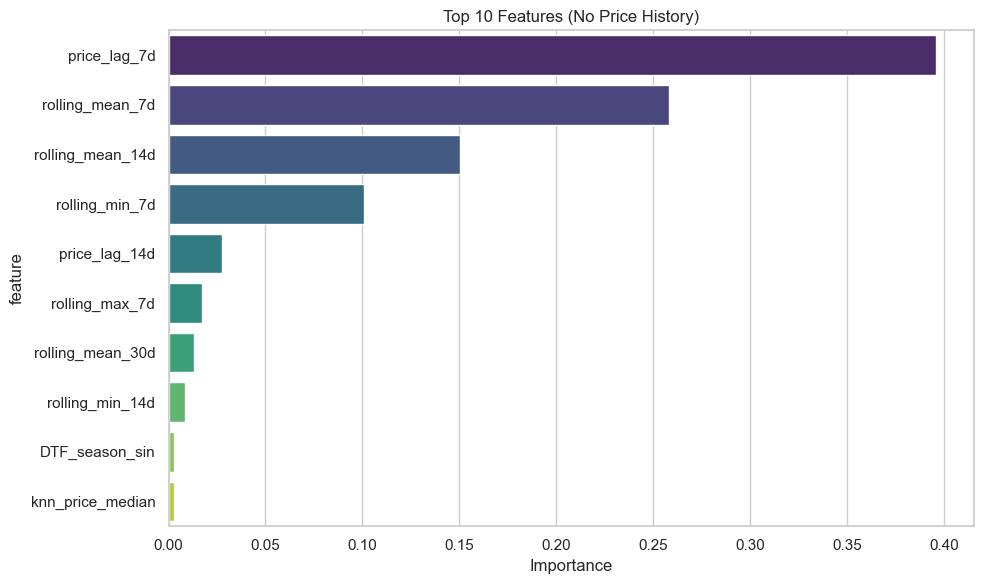

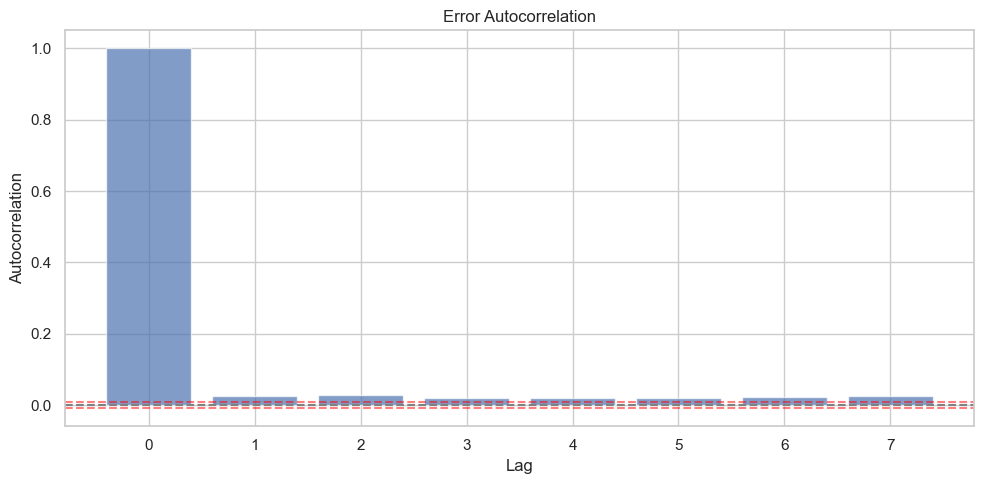

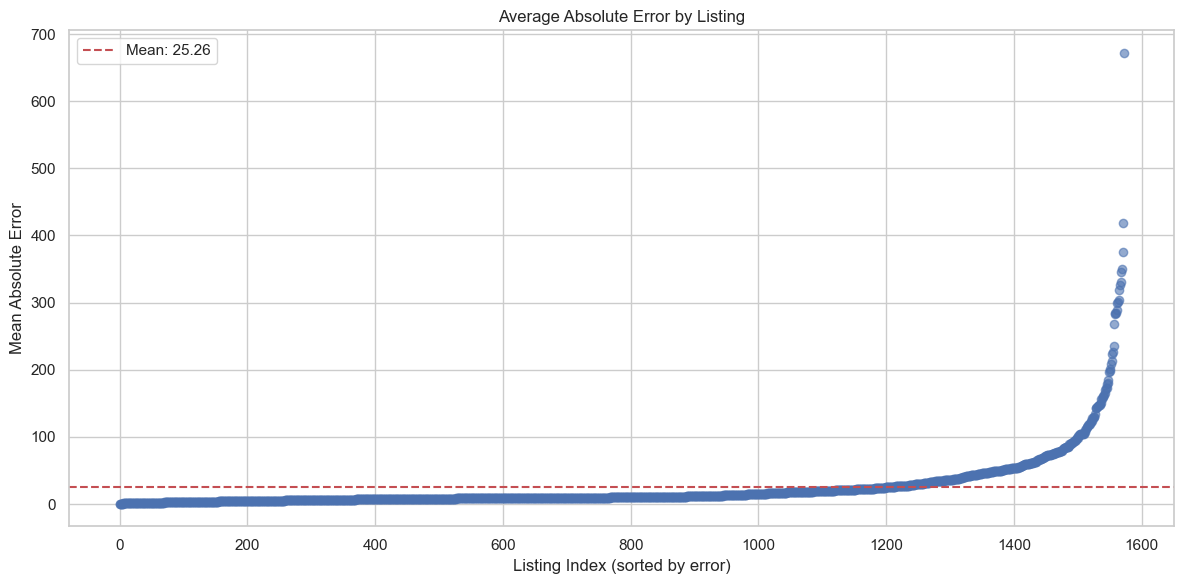

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
from sklearn.neighbors import BallTree
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import math
import warnings
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1, train_data_only=None):
    """Enhanced spatial features while maintaining existing structure
    
    Parameters:
    -----------
    df : DataFrame
        The data to create features for
    k_neighbors : int
        Number of neighbors to use for KNN features
    chunk_size : int
        Size of chunks for parallel processing
    n_jobs : int
        Number of parallel jobs
    train_data_only : DataFrame, optional
        If provided, use only this data for computing the KNN features
        This prevents data leakage by ensuring test listings don't influence each other
    """
    # Adjust k_neighbors if the dataset is small
    reference_data = train_data_only if train_data_only is not None else df
    actual_k = min(k_neighbors, len(reference_data) - 1)  # Make sure k is at most n-1
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': []
        # 'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    # Use only training data for the reference tree to prevent data leakage
    all_coords = np.radians(reference_data[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = reference_data['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, we need special handling
        if k_query == 1:
            # Just return zeros or appropriate values for a single point
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                # 'price_diff_from_neighbors': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data if we have multiple points
        # Handle the case where k_query is 2 (self + 1 neighbor)
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))  # Only one neighbor, so weight is 1
        else:
            # Convert distances to weights (inverse distance weighting)
            weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore NaN warnings
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            # Handle single-neighbor case for median and range
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            # Weighted prices
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            # 'price_diff_from_neighbors': chunk_data['price'].values - mean_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,  # Use adjusted k value
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0  # Set to zero if std is zero
    
    return spatial_features

def run_rolling_window_xgboost(train_path, train_ids_path, test_ids_path, output_dir=None, window_size=35, n_splits=5, sample_size=None):
    """
    Run XGBoost with rolling window cross-validation for predicting prices without price history.
    Uses separate listing IDs for training and testing to prevent data leakage.
    Applies log transformation to prices during training and transforms back for evaluation.
    
    Parameters:
    -----------
    train_path : str
        Path to the Topic2_Train.csv file
    train_ids_path : str
        Path to text file with training listing IDs
    test_ids_path : str
        Path to text file with test listing IDs
    output_dir : str, optional
        Directory to save results
    window_size : int, optional
        Size of the rolling window in days
    n_splits : int, optional
        Number of splits for time series cross-validation
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Load listing IDs for train/test split
    print("Loading train/test listing IDs...")
    with open(train_ids_path, 'r') as f:
        train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
    with open(test_ids_path, 'r') as f:
        test_listing_ids = [int(line.strip()) for line in f.readlines()]
    
    print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")

    # Drop the price_lag_1d column if it exists
    if 'price_lag_1d' in train_data.columns:
        print("Dropping price_lag_1d column from the dataset")
        train_data = train_data.drop('price_lag_1d', axis=1)
    
    if 'simulated_price' in train_data.columns:
        print("Dropping simulated_price column from the dataset")
        train_data = train_data.drop('simulated_price', axis=1)
        
    # Apply log transformation to prices
    train_data = apply_price_transformation(train_data, inverse=False)
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.7), replace=False)
        selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.3), replace=False)
        train_listing_ids = selected_train.tolist()
        test_listing_ids = selected_test.tolist()
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 2/8/24 (as specified)
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Check if we have data for the entire expected range
    print(f"Date range in filtered data: {train_data['date'].min()} to {train_data['date'].max()}")
    print(f"Number of days with data: {len(train_data['date'].dt.date.unique())}")

    # Get unique dates and ensure they are properly sorted
    unique_dates = sorted(train_data['date'].dt.date.unique())
    first_date = unique_dates[0]
    last_date = unique_dates[-1]

    # Check if there's a gap between the expected start date and actual first date
    if first_date > start_date.date():
        print(f"Warning: No data found between {start_date.date()} and {first_date}")
        print(f"Using available data starting from {first_date}")
    
    # Sort by date
    train_data = train_data.sort_values('date')
    
    # Create explicit test periods - last 5 weeks (35 days) split into 5 equal parts (7 days each)
    last_35_days = unique_dates[-35:]
    
    # Define explicit test periods - each 7 days
    test_periods = []
    for i in range(n_splits):
        start_idx = i * 7
        end_idx = start_idx + 7
        # Make sure we don't go beyond the available data
        if end_idx <= len(last_35_days):
            test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
    
    # Adjust n_splits if we couldn't create enough test periods
    n_splits = len(test_periods)
    
    print(f"Created {n_splits} test periods:")
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"  Period {i+1}: {test_start} to {test_end}")
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Storage for results
    cv_results = []
    feature_importance_over_time = []
    
    # Run time series cross-validation using our explicit test periods
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"\nSplit {i+1}/{n_splits}")
        
        # Define training period: everything before test_start
        train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
        train_end_date = train_end.date()
        
        print(f"Training period: {unique_dates[0]} to {train_end_date}")
        print(f"Testing period: {test_start} to {test_end}")
        
        # Split by date first
        train_date_mask = train_data['date'].dt.date <= train_end_date
        test_date_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
        
        date_filtered_train = train_data[train_date_mask]
        date_filtered_test = train_data[test_date_mask]
        
        # Now further split by listing IDs
        train_id_mask = date_filtered_train['listing_id'].isin(train_listing_ids)
        test_id_mask = date_filtered_test['listing_id'].isin(test_listing_ids)
        
        split_train_data = date_filtered_train[train_id_mask]
        split_test_data = date_filtered_test[test_id_mask]
        
        print(f"Train data: {len(split_train_data)} rows, {len(split_train_data['listing_id'].unique())} unique listings")
        print(f"Test data: {len(split_test_data)} rows, {len(split_test_data['listing_id'].unique())} unique listings")
        
        # Create spatial features using only training data as reference
        # Pass training data to prevent leakage
        full_train_data = train_data[train_data['listing_id'].isin(train_listing_ids)]
        train_spatial = create_spatial_features(split_train_data, train_data_only=full_train_data)
        test_spatial = create_spatial_features(split_test_data, train_data_only=full_train_data)
        
        # Prepare feature matrices
        X_train = pd.concat([
            split_train_data.drop(['listing_id', 'date', 'price', 'original_price'], axis=1), 
            train_spatial
        ], axis=1)
        
        X_test = pd.concat([
            split_test_data.drop(['listing_id', 'date', 'price', 'original_price'], axis=1), 
            test_spatial
        ], axis=1)
        
        y_train = split_train_data['price']  # This is log-transformed price
        y_test = split_test_data['price']    # This is log-transformed price
        
        # Store original prices for later evaluation
        y_test_original = split_test_data['original_price'].values
        
        # Ensure X_train and X_test have the same columns
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
            
        # Ensure the columns are in the same order
        X_test = X_test[X_train.columns]
        
        # Train the model
        print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        # Make predictions (still in log-transformed space)
        y_pred_log = xgb_model.predict(X_test)
        
        # Create a temporary dataframe to transform predictions back
        temp_pred_df = pd.DataFrame({'price': y_pred_log})
        temp_pred_df = apply_price_transformation(temp_pred_df, inverse=True)
        y_pred = temp_pred_df['price'].values
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'split': i
        })
        feature_importance_over_time.append(feature_importance)
        
        # Calculate metrics using the original price scale
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
        mae = mean_absolute_error(y_test_original, y_pred)
        r2 = r2_score(y_test_original, y_pred) if len(set(y_test_original)) > 1 else np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test_original - y_pred) / (y_test_original + 1e-8))) * 100
        
        print(f"Split {i+1} Results - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
        
        # Store results for this split
        split_results = pd.DataFrame({
            'split': i,
            'date': split_test_data['date'],
            'listing_id': split_test_data['listing_id'],
            'price': y_test_original,  # Original price scale
            'predicted': y_pred,       # Original price scale
            'error': y_test_original - y_pred,
            'abs_error': np.abs(y_test_original - y_pred),
            'pct_error': np.abs((y_test_original - y_pred) / (y_test_original + 1e-8)) * 100
        })
        
        cv_results.append(split_results)
    
    # Combine all results
    all_results = pd.concat(cv_results, ignore_index=True)
    all_feature_importance = pd.concat(feature_importance_over_time, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price']  # This is in original price scale from our changes above
    y_pred = all_results['predicted']  # This is in original price scale from our changes above
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate split-level metrics
    split_metrics = []
    for split in range(n_splits):
        split_data = all_results[all_results['split'] == split]
        if not split_data.empty:
            y_true_split = split_data['price']
            y_pred_split = split_data['predicted']
            
            split_metrics.append({
                'split': split,
                'rmse': np.sqrt(mean_squared_error(y_true_split, y_pred_split)),
                'mae': mean_absolute_error(y_true_split, y_pred_split),
                'r2': r2_score(y_true_split, y_pred_split) if len(set(y_true_split)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_split - y_pred_split) / (y_true_split + 1e-8))) * 100,
                'n_samples': len(y_true_split)
            })
    
    split_metrics_df = pd.DataFrame(split_metrics)
    
    # Calculate daily metrics
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    daily_metrics = []
    for day, group in all_results.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    # Error analysis
    errors = all_results['error'].values
    error_autocorr = acf(errors, nlags=7)[1:]  # Exclude lag 0
    
    # Create a results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'split_metrics': split_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'feature_importance': all_feature_importance,
        'error_autocorrelation': error_autocorr,
        'train_listings': len(train_listing_ids),
        'test_listings': len(test_listing_ids)
    }
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save all results
        results_file = os.path.join(output_dir, 'xgboost_listing_split_results.csv')
        all_results.to_csv(results_file, index=False)
        print(f"Results saved to {results_file}")
        
        # Save metrics
        metrics_file = os.path.join(output_dir, 'xgboost_listing_split_metrics.csv')
        daily_metrics_df.to_csv(metrics_file, index=False)
        print(f"Daily metrics saved to {metrics_file}")
        
        # Save feature importance
        importance_file = os.path.join(output_dir, 'xgboost_listing_split_feature_importance.csv')
        all_feature_importance.to_csv(importance_file, index=False)
        print(f"Feature importance saved to {importance_file}")
        
        # Save summary
        with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
            f.write(f"XGBoost Rolling Window CV Model Summary with Listing ID Split (Log-transformed prices)\n")
            f.write(f"=======================================================================\n\n")
            f.write(f"Window size: {window_size} days\n")
            f.write(f"Number of splits: {n_splits}\n")
            f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n")
            f.write(f"Number of training listings: {len(train_listing_ids)}\n")
            f.write(f"Number of test listings: {len(test_listing_ids)}\n\n")
            f.write(f"Overall Metrics (on original price scale):\n")
            for k, v in overall_metrics.items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print_rolling_window_summary(evaluation_results)
    
    # Create plots
    plot_rolling_window_results(evaluation_results)
    
    return evaluation_results

def print_rolling_window_summary(evaluation_results):
    """Print a summary of rolling window cross-validation results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    # Print new info about listing splits if available
    train_listings = evaluation_results.get('train_listings', 'N/A')
    test_listings = evaluation_results.get('test_listings', 'N/A')
    
    print("\n===== ROLLING WINDOW XGBOOST MODEL WITH LISTING ID SPLIT =====")
    if train_listings != 'N/A':
        print(f"Using {train_listings} listings for training and {test_listings} listings for testing")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    # Calculate overall feature importance by averaging across splits
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features (No Price History) ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_rolling_window_results(evaluation_results):
    """Plot the results from rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Add title showing we're using listing ID split
    fig.suptitle('XGBoost Model Evaluation with Listing ID Split', fontsize=16)
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Create plot for feature importance
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.groupby('feature')['importance'].mean().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette='viridis'
    )
    plt.title('Top 10 Features (No Price History)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation
    error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
    lags = range(len(error_acf))
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, error_acf, alpha=0.7)
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Error Autocorrelation')
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Performance by listing ID count
    # Group by listing ID and calculate average absolute error for each listing
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    listing_errors = listing_errors.sort_values('abs_error')
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(listing_errors)), listing_errors['abs_error'], alpha=0.6)
    plt.axhline(y=listing_errors['abs_error'].mean(), color='r', linestyle='--', 
                label=f'Mean: {listing_errors["abs_error"].mean():.2f}')
    plt.title('Average Absolute Error by Listing')
    plt.xlabel('Listing Index (sorted by error)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Path to data files
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_up3.csv"
    train_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt"
    test_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt"
    
    # Output directory
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_ListingSplit"
    
    # Run the model
    results = run_rolling_window_xgboost(
        train_path=train_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        output_dir=output_dir,
        window_size=35,  # 5 weeks
        n_splits=5,
        sample_size=None  # Set to a number like 1000 for testing, None to use all data
    )